### DinamicStars - algorithm for matching stars patterns

To identify the processes occurring in the near-earth space, it is often required to analyze images. To determine the place of the process, scientists are guided by the position of the stars, the position of which can be found from the star catalog. Thus to point the location of the processes we need to compare stars from an image and those from the catalog.

The algorithm should work with the following image damages: noise, perspective distortion, distortion. The algorithm should work with the following image damages: noise, perspective distortion, distortion. At the moment, there are many algorithms that allow you to compare stars with each other. This task will discuss the author's algorithm and its behavior under various image deformations, and it will also be compared with one of the well-known star matching algorithms.

### Algorithm

#### Data structure

The first part of algorithm - representation data in specially data stucture - Star. 

The Star  data structure contane 5 field: 

* indx - index of star; 
* position - star position in Cartesian system;
* neighbours - the link to other stars presented in Star data structure;
* rots - array of angles between target star position and neghbour star position.

**Algoritm**

First, the arrays stars_1 and stars_2 are initialized - they store data about stars formatted into the Star data structure.
An array is initialized, the same size as stars_1, it will store the mappings between the stars: in each cell the index of the star from the list stars_2, which best suits the star from the list stars_1.
Then, looking over the stars among themselves, the stars are searched for with the maximum LCS_DYN metric.
In turn, the LCS_DYN algorithm is an algorithm for finding the **longest common subsequence**. It compares lists of angles to stars from two lists. In other words, the hypothesis of the algorithm: the corresponding stars from two images will have the longest common subsequence on the sorted list of angles between the target star and the neighboring ones.

Below is the pseudocode.
 

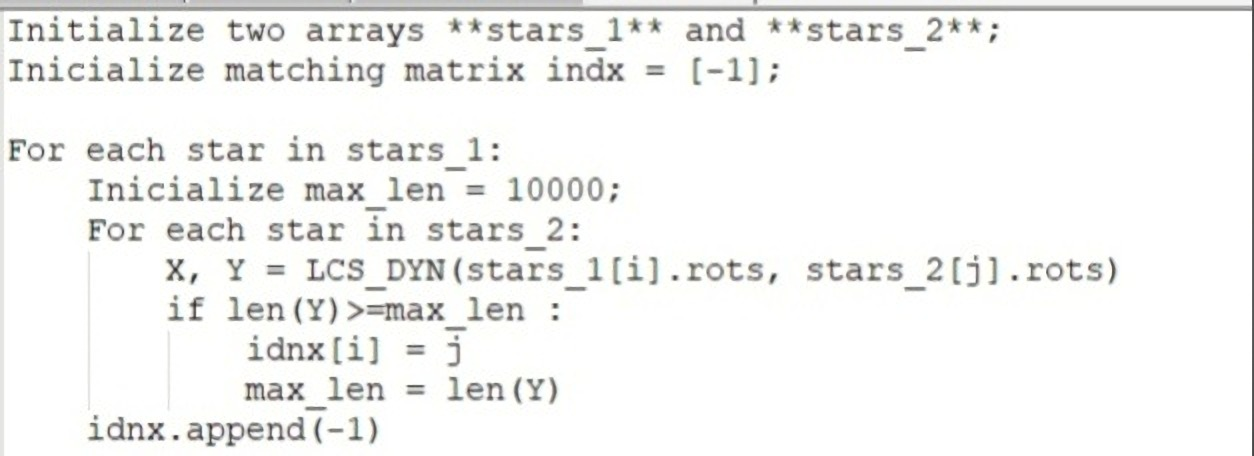

### Analysis approach

**Data**: For analysis, 1 picture is generated - this is the original position of the stars and several pictures with added noise and different geometric distortions

To evaluate the effectiveness of the algorithm, you need to evaluate the following characteristics:

1 - Accuracy. to estimate it, you can calculate the standard deviation of the distances (std) between the compared stars. Since in the example only geometric distortions and reversals are considered, the standard should not be large.

2 - Execution time of the algorithm depending on the different number of stars.

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy.spatial import distance
from scipy.optimize import linear_sum_assignment
from skimage.measure import label, regionprops

In [98]:
def get_stars_coords(points):
    coords = []
    for point in points:
        coords.append(point.centroid)
    return coords

def fill_dyn_matrix(x, y):
    L = [[0]*(len(y)+1) for _ in range(len(x)+1)]
    for x_i,x_elem in enumerate(x):
        for y_i,y_elem in enumerate(y):
            if abs(x_elem - y_elem)<20:
                L[x_i][y_i] = L[x_i-1][y_i-1] + 1
            else:
                L[x_i][y_i] = max((L[x_i][y_i-1],L[x_i-1][y_i]))
    return L


def LCS_DYN(x, y):
    L = fill_dyn_matrix(x, y)
    LCS_x = []
    LCS_y = []
    indx_x = []
    indx_y = []
    x_i,y_i = len(x)-1,len(y)-1
    while x_i >= 0 and y_i >= 0:
        if abs(x[x_i] - y[y_i])<10:
            LCS_x.append(x[x_i])
            LCS_y.append(y[y_i])
            
            indx_x.append(x_i)
            indx_y.append(y_i)
            x_i, y_i = x_i-1, y_i-1
        elif L[x_i-1][y_i] > L[x_i][y_i-1]:
            x_i -= 1
        else:
            y_i -= 1
    LCS_x.reverse()
    LCS_y.reverse()
    return LCS_x, LCS_y

def accuracy(X, Y):
    dst = [distance.euclidean(x, y) for x,y in zip(X,Y)]
    print(dst)
    return np.std(dst)

In [99]:
class Star:
    def __init__(self, indx, x, y):
        self.indx = indx
        self.position = (x,y)
        self.neighbours = []
        self.rots = []
        self.distance = []
        self.nearest = []
        self.nearest_indx = []
       #self.__init_neighbours()
        
    def __str__(self):
        return "idx = %d, x = %d, y = %d"%(self.indx, self.position[0], self.position[1])
    
    def init_neighbours(self, stars):
        self.neighbours = np.asarray(sorted(stars, key = lambda s: distance.euclidean(self.position,s.position)))
        self.rots = [math.degrees(math.atan2(self.position[0] - s.position[0],
                                             self.position[1] - s.position[1])) for s in self.neighbours ]
        
def activate_stars(stars):
    for s in stars:
        s.init_neighbours(stars)

    

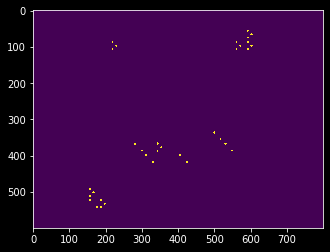

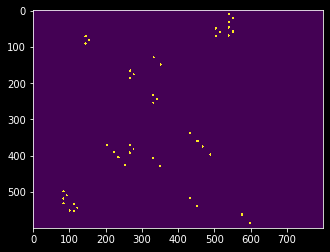

In [100]:
stars_1 = plt.imread("set_4/p1.png")
stars_2 = plt.imread("set_4/p3.png")
plt.imshow(stars_1)
plt.show()
plt.imshow(stars_2)
plt.show()

In [101]:
LB_image1 = label(stars_1)
points_imgage1 = regionprops(LB_image1)

LB_image2 = label(stars_2)
points_imgage2 = regionprops(LB_image2)

In [102]:
stars_coords_1 = np.asarray(get_stars_coords(points_imgage1))
stars_coords_2 = np.asarray(get_stars_coords(points_imgage2))

In [103]:
stars_1= [Star(i, stars_coords_1[i][0], stars_coords_1[i][1]) for i in range(len(stars_coords_1))]
stars_2= [Star(i, stars_coords_2[i][0], stars_coords_2[i][1]) for i in range(len(stars_coords_2))]

activate_stars(stars_1)
activate_stars(stars_2)

In [104]:
idnx = [-1]
distanc = [1000]

for i in range(0,len(stars_1)):
    max_len = 0 
    for j in range(0,len(stars_2)):
        X, Y = LCS_DYN(stars_1[i].rots, stars_2[j].rots)
        dist_xy  = distance.euclidean(X,Y)
        if len(Y)>=max_len :
            idnx[i] = j
            distanc[i] = len(Y)
            max_len = len(Y)
    idnx.append(-1)
    distanc.append(1000)
    

In [105]:
indx_1 = [s.indx for s in stars_1]
std = np.std(distanc[:-1])
thresh =  np.mean(distanc[:-1]) - std

mean_thresh = int(len(indx_1)*0.6)
indx_ = sorted(list(zip(indx_1,idnx,distanc)), key = lambda e: e[-1])[::-1]

last_indx = np.where(np.asarray(indx_)[:,2] > thresh)[0][-1]
indx_1 = np.asarray([i[0] for i in indx_])
indx_2 = np.asarray([i[1] for i in indx_])

for i in range(1,len(indx_1)):
    if len(np.where(indx_1==i)[0])>1:
        indx_1[indx_1==i] = -1
        indx_2[indx_2==i] = -1


Звезды из каталога
Звезды со снимка
[76.24857762325249, 76.65825347468301, 60.840001344699864, 68.80476585955842, 75.31811793246622, 77.56201333261343, 63.072229782808954, 66.25772507057944, 75.93616793070349, 69.1910541051688, 75.90751168556785, 73.83299549991045, 74.24217474053467, 77.63712131850362, 64.08748667239182, 66.03314730775254, 67.14400661437372, 67.18529247405044, 74.69171580626067, 76.77276930161457, 76.89467256190623, 67.2321515677631, 73.80620363116128, 73.4278683465947, 74.29903917428695, 77.57444574071022, 76.81927610017914, 64.01158404987096, 66.93765608192697]
5.188855053499582


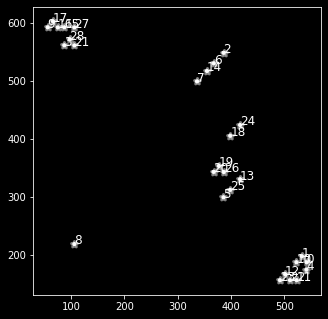

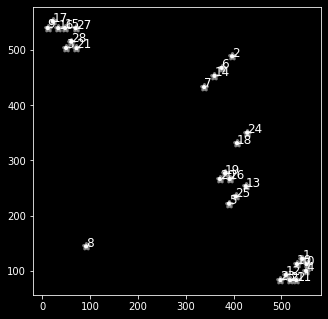

In [106]:
from plotter import plot_sky_image

print("Звезды из каталога")
#stars_catalog = np.append(stars_catalog[:8], stars_catalog[:8])

plot_sky_image(stars_coords_1[indx_1][:last_indx], text = True)
print("Звезды со снимка")

#print(len(stars_image))
plot_sky_image(stars_coords_2[indx_2][:last_indx], text = True)

print(accuracy(stars_coords_1[indx_1][:last_indx], stars_coords_2[indx_2][:last_indx]))

### Algoritm complexity

In [107]:
import time

Inicialization complexity

In [110]:
init_time = []
for i in range(1000):
    stars_coords_1 = np.random.randint(0,500,size = [i,2])
    stars_coords_2 = np.random.randint(0,500,size = [i,2])
    
    a = time.time()
    stars_1= [Star(i, stars_coords_1[i][0], stars_coords_1[i][1]) for i in range(len(stars_coords_1))]
    stars_2= [Star(i, stars_coords_2[i][0], stars_coords_2[i][1]) for i in range(len(stars_coords_2))]

    activate_stars(stars_1)
    activate_stars(stars_2)
    b = time.time()
    
    init_time.append((b-a))

KeyboardInterrupt: 

In [140]:
def f(x):
    return x**2

theretical = [f(x)*0.00008 for x in range(1000)]

Text(0, 0.5, 'time')

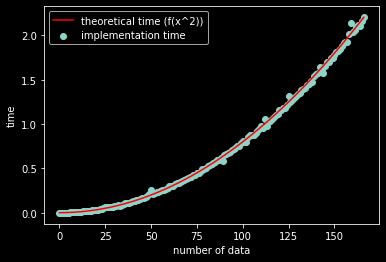

In [146]:
plt.scatter(range(len(init_time)),init_time, label = "implementation time")
plt.plot(range(len(init_time)),theretical[:len(init_time)], label = "theoretical time (f(x^2))", color = 'r')
plt.legend()
plt.xlabel("number of data")
plt.ylabel("time")


In [147]:
def match(stars_1, stars_2):
    idnx = [-1]
    distanc = [1000]

    for i in range(0,len(stars_1)):
        max_len = 0 
        for j in range(0,len(stars_2)):
            X, Y = LCS_DYN(stars_1[i].rots, stars_2[j].rots)
            dist_xy  = distance.euclidean(X,Y)
            if len(Y)>=max_len :
                idnx[i] = j
                distanc[i] = len(Y)
                max_len = len(Y)
        idnx.append(-1)
        distanc.append(1000)
    return idnx

In [221]:
match_time = []
for i in range(100):
    stars_coords_1 = np.random.randint(0,500,size = [i,2])
    stars_coords_2 = np.random.randint(0,500,size = [i,2])
    
    
    stars_1= [Star(i, stars_coords_1[i][0], stars_coords_1[i][1]) for i in range(len(stars_coords_1))]
    stars_2= [Star(i, stars_coords_2[i][0], stars_coords_2[i][1]) for i in range(len(stars_coords_2))]

    activate_stars(stars_1)
    activate_stars(stars_2)
    
    a = time.time()
    match(stars_1, stars_2)
    b = time.time()
    
    match_time.append((b-a))

KeyboardInterrupt: 

In [233]:
def f(x):
    return x**3

theretical = [f(x*0.040)*0.42 for x in range(1000)]

Text(0, 0.5, 'time')

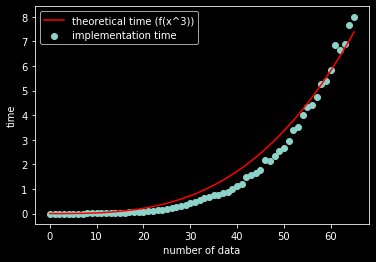

In [235]:
plt.scatter(range(len(match_time)),match_time, label = "implementation time")
plt.plot(range(len(match_time)),theretical[:len(match_time)], label = "theoretical time (f(x^3))", color = 'r')
plt.legend()
plt.xlabel("number of data")
plt.ylabel("time")


In [224]:
600 - 500


100